##  Multi-class Disease Classification Project

  This project aims to develop a robust machine learning pipeline to classify diseases based on patient demographic and
  laboratory data. We utilize a variety of classification algorithms, handle class imbalance using SMOTE, and interpret
  model predictions using SHAP.

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

 # Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
classification_report, confusion_matrix, accuracy_score,
precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Interpretability
import shap

# Settings
%matplotlib inline
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')


c:\Users\nanaa\anaconda3\envs\myPythonenv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Exploratory Data Analysis (EDA)

  We start by loading the dataset and examining its structure to understand the features and the target variable.

In [3]:
# Load dataset
df = pd.read_csv('laboratory__data.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

print("Dataset Shape:", df.shape)
print("\nData Types and Missing Values:")
print(df.info())

# Summary Statistics
print("\nSummary Statistics for Numerical Features:")
display(df.describe())

# Check for missing values explicitly
print("\nMissing Values Count:")
print(df.isnull().sum())


Dataset Shape: (12009, 14)

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12009 entries, 0 to 12008
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            12009 non-null  object 
 1   Age                               12009 non-null  int64  
 2   Hemoglobin                        12009 non-null  int64  
 3   RBC                               12009 non-null  float64
 4   WBC                               12009 non-null  int64  
 5   AST (aspartate aminotransferase)  12009 non-null  int64  
 6   ALT (alanine aminotransferase)    12009 non-null  int64  
 7   Cholestrol                        12009 non-null  int64  
 8   Spirometry                        12009 non-null  float64
 9   Creatinine                        12009 non-null  float64
 10  Glucose                           12009 non-null  int64  
 11  Lipase  

,Age,Hemoglobin,RBC,WBC,AST (aspartate aminotransferase),ALT (alanine aminotransferase),Cholestrol,Spirometry,Creatinine,Glucose,Lipase,Troponin
count,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,54.415438,11.988342,3.421939,9154.022317,24.613457,31.168873,217.975685,3.798141,1.099124,90.801815,101.816554,0.027720
std,21.160408,4.681409,1.925999,3922.574987,8.150145,11.565622,13.956727,0.887210,0.295349,18.361879,27.901340,0.023478
min,18.000000,2.000000,0.110000,6005.000000,15.000000,20.000000,200.000000,1.010000,0.800000,70.000000,70.000000,0.000000
25%,36.000000,6.000000,1.120000,7061.000000,19.000000,24.000000,208.000000,3.390000,0.910000,78.000000,83.000000,0.010000
50%,55.000000,14.000000,4.000000,8187.000000,23.000000,28.000000,216.000000,3.940000,1.030000,87.000000,97.000000,0.020000
75%,73.000000,15.000000,4.530000,9207.000000,28.000000,33.000000,224.000000,4.440000,1.140000,96.000000,110.000000,0.030000
max,90.000000,50.000000,34.000000,27901.000000,50.000000,70.000000,281.000000,5.010000,2.000000,157.000000,202.000000,0.100000



Missing Values Count:
Gender                              0
Age                                 0
Hemoglobin                          0
RBC                                 0
WBC                                 0
AST (aspartate aminotransferase)    0
ALT (alanine aminotransferase)      0
Cholestrol                          0
Spirometry                          0
Creatinine                          0
Glucose                             0
Lipase                              0
Troponin                            0
Disease                             0
dtype: int64


In [4]:
df.head()

,Gender,Age,Hemoglobin,RBC,WBC,AST (aspartate aminotransferase),ALT (alanine aminotransferase),Cholestrol,Spirometry,Creatinine,Glucose,Lipase,Troponin,Disease
0,Male,59,6,1.20,6220,26,22,227,4.75,0.90,96,97,0.02,Anemia
1,Male,71,40,20.00,6636,18,27,220,3.93,1.03,94,82,0.04,Asthma
2,Female,22,14,3.55,18314,21,30,224,3.93,1.17,70,101,0.00,Infection
3,Male,53,16,4.95,9931,45,62,205,3.58,0.81,82,108,0.03,Liver Disease
4,Male,77,16,3.96,7088,29,25,217,3.20,1.70,97,107,0.04,Liver Disease


#### Target Variable Distribution
##### Understanding the balance of classes in the Disease target variable is crucial for deciding on sampling strategies.

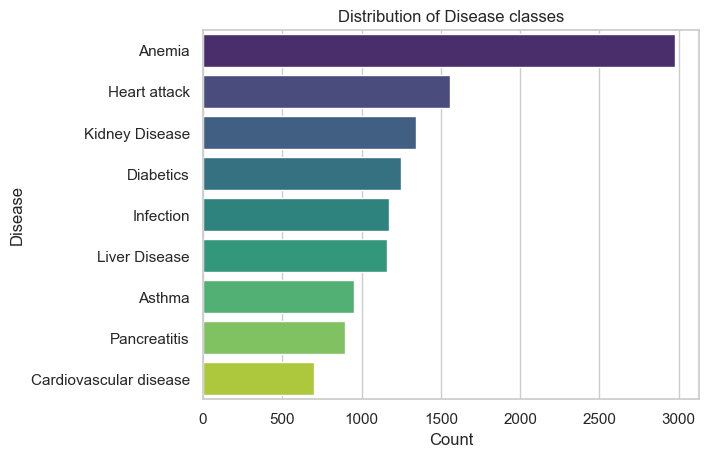

Disease Class Counts:
Disease
Anemia                    2979
Heart attack              1555
Kidney Disease            1341
Diabetics                 1251
Infection                 1176
Liver Disease             1162
Asthma                     955
Pancreatitis               893
Cardiovascular disease     697
Name: count, dtype: int64


In [5]:
plt.Figure(figsize=(12, 6))
sns.countplot(data=df, y='Disease', order=df['Disease'].value_counts().index, palette='viridis')
plt.title('Distribution of Disease classes')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

print("Disease Class Counts:")
print(df['Disease'].value_counts())

#### Feature Distribution
##### I visualized the distribution of different numerical laboratory tests to detect skewness and potential outliers 

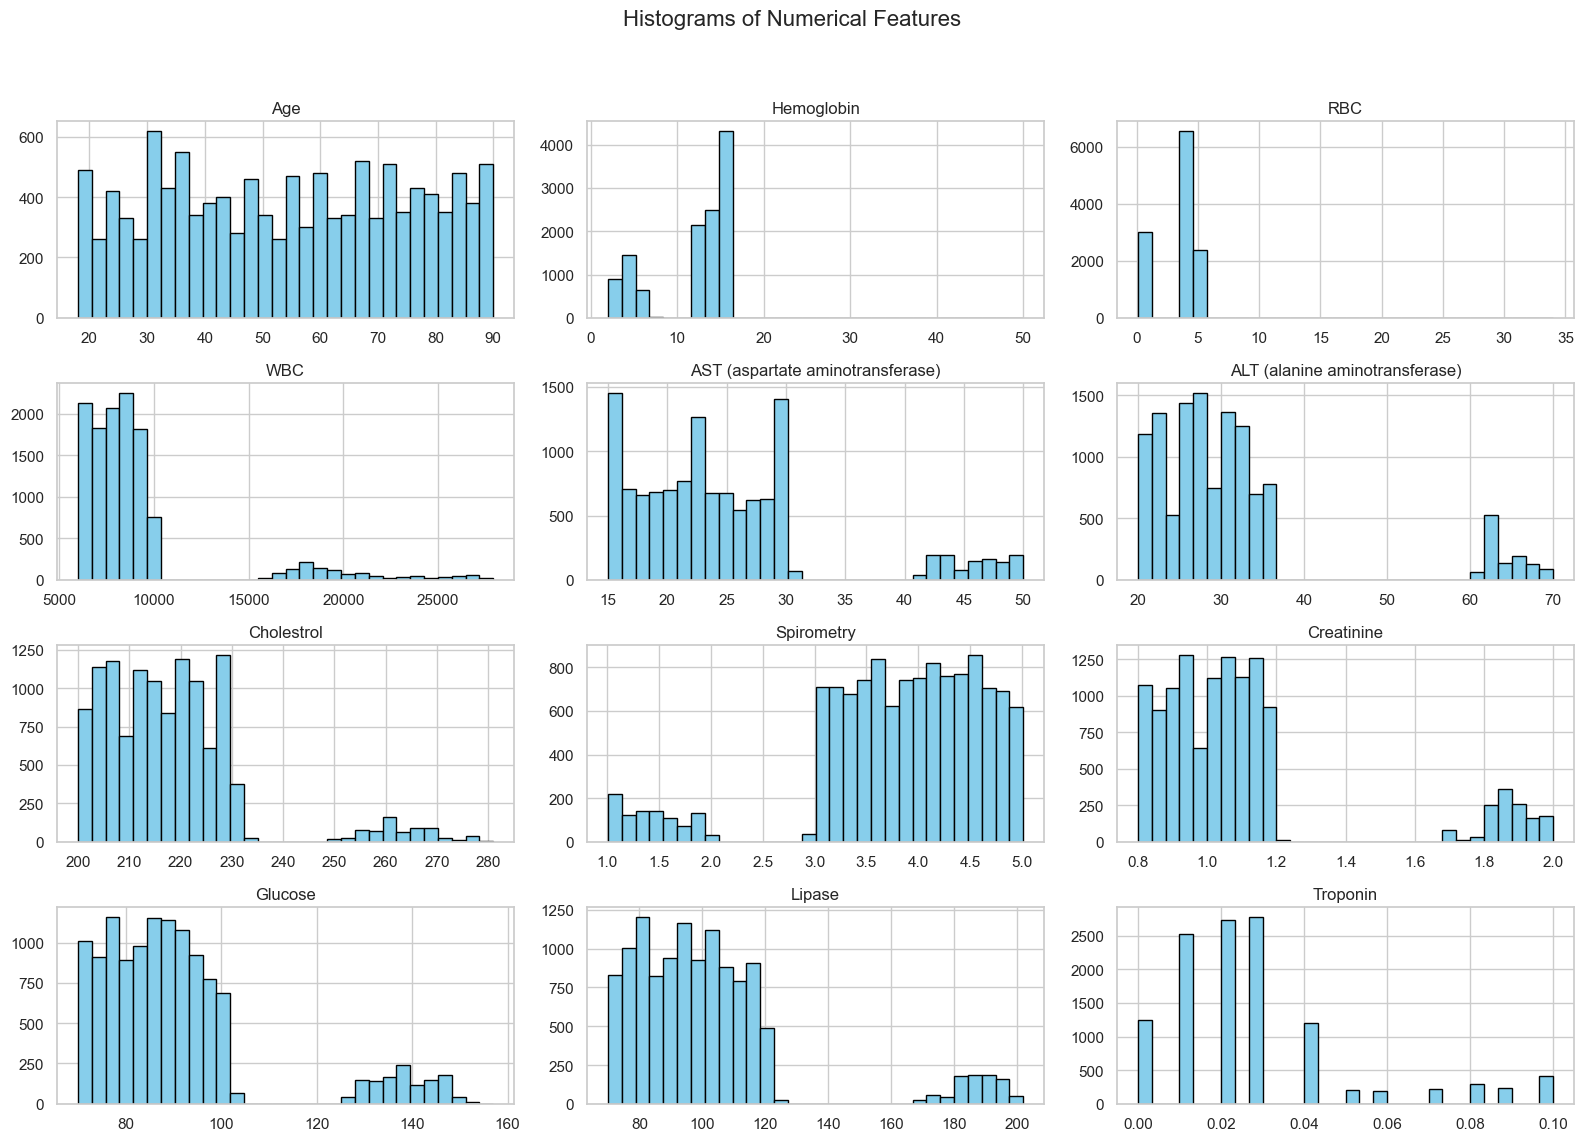

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols].hist(bins=30, figsize=(16, 12), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Correlation Analysis
##### Created a heatmap to visualize and detect collinearlity in the features 

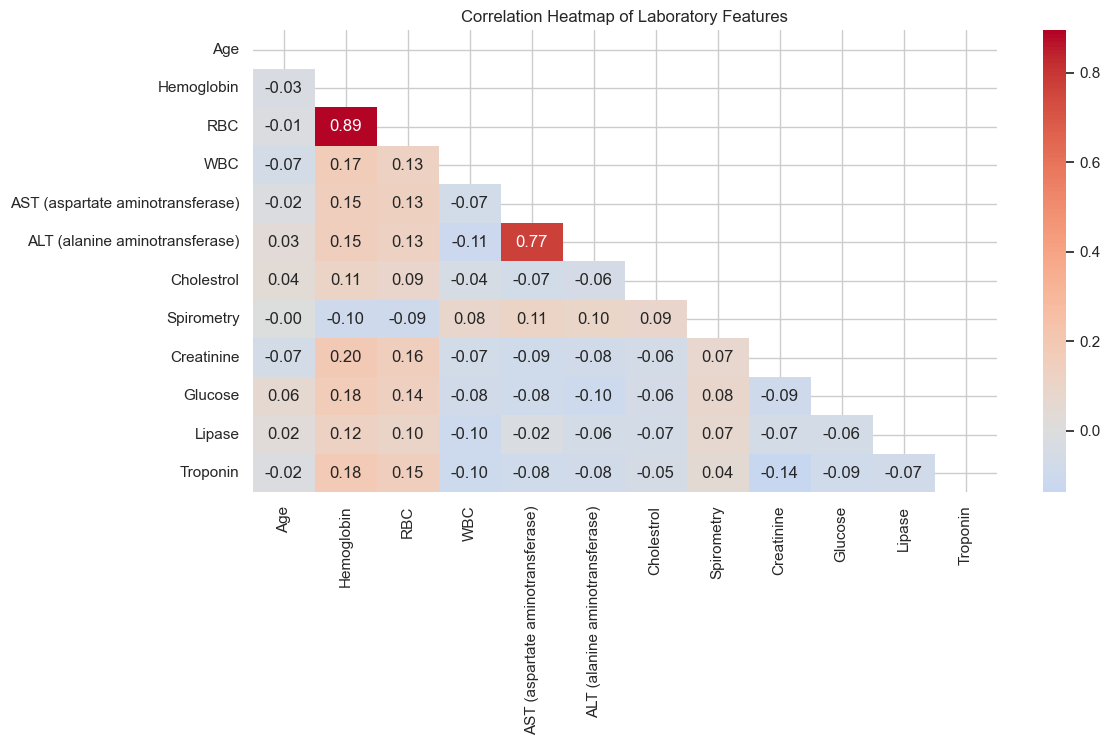

In [7]:
plt.figure(figsize=(12, 6))
corrr = df[num_cols].corr()
mask = np.triu(np.ones_like(corrr, dtype=bool))
sns.heatmap(corrr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Heatmap of Laboratory Features')
plt.show()

#### Feature Distribution by Disease Class
##### Using a boxplot to visualize how laboratory test values differ across various disease category

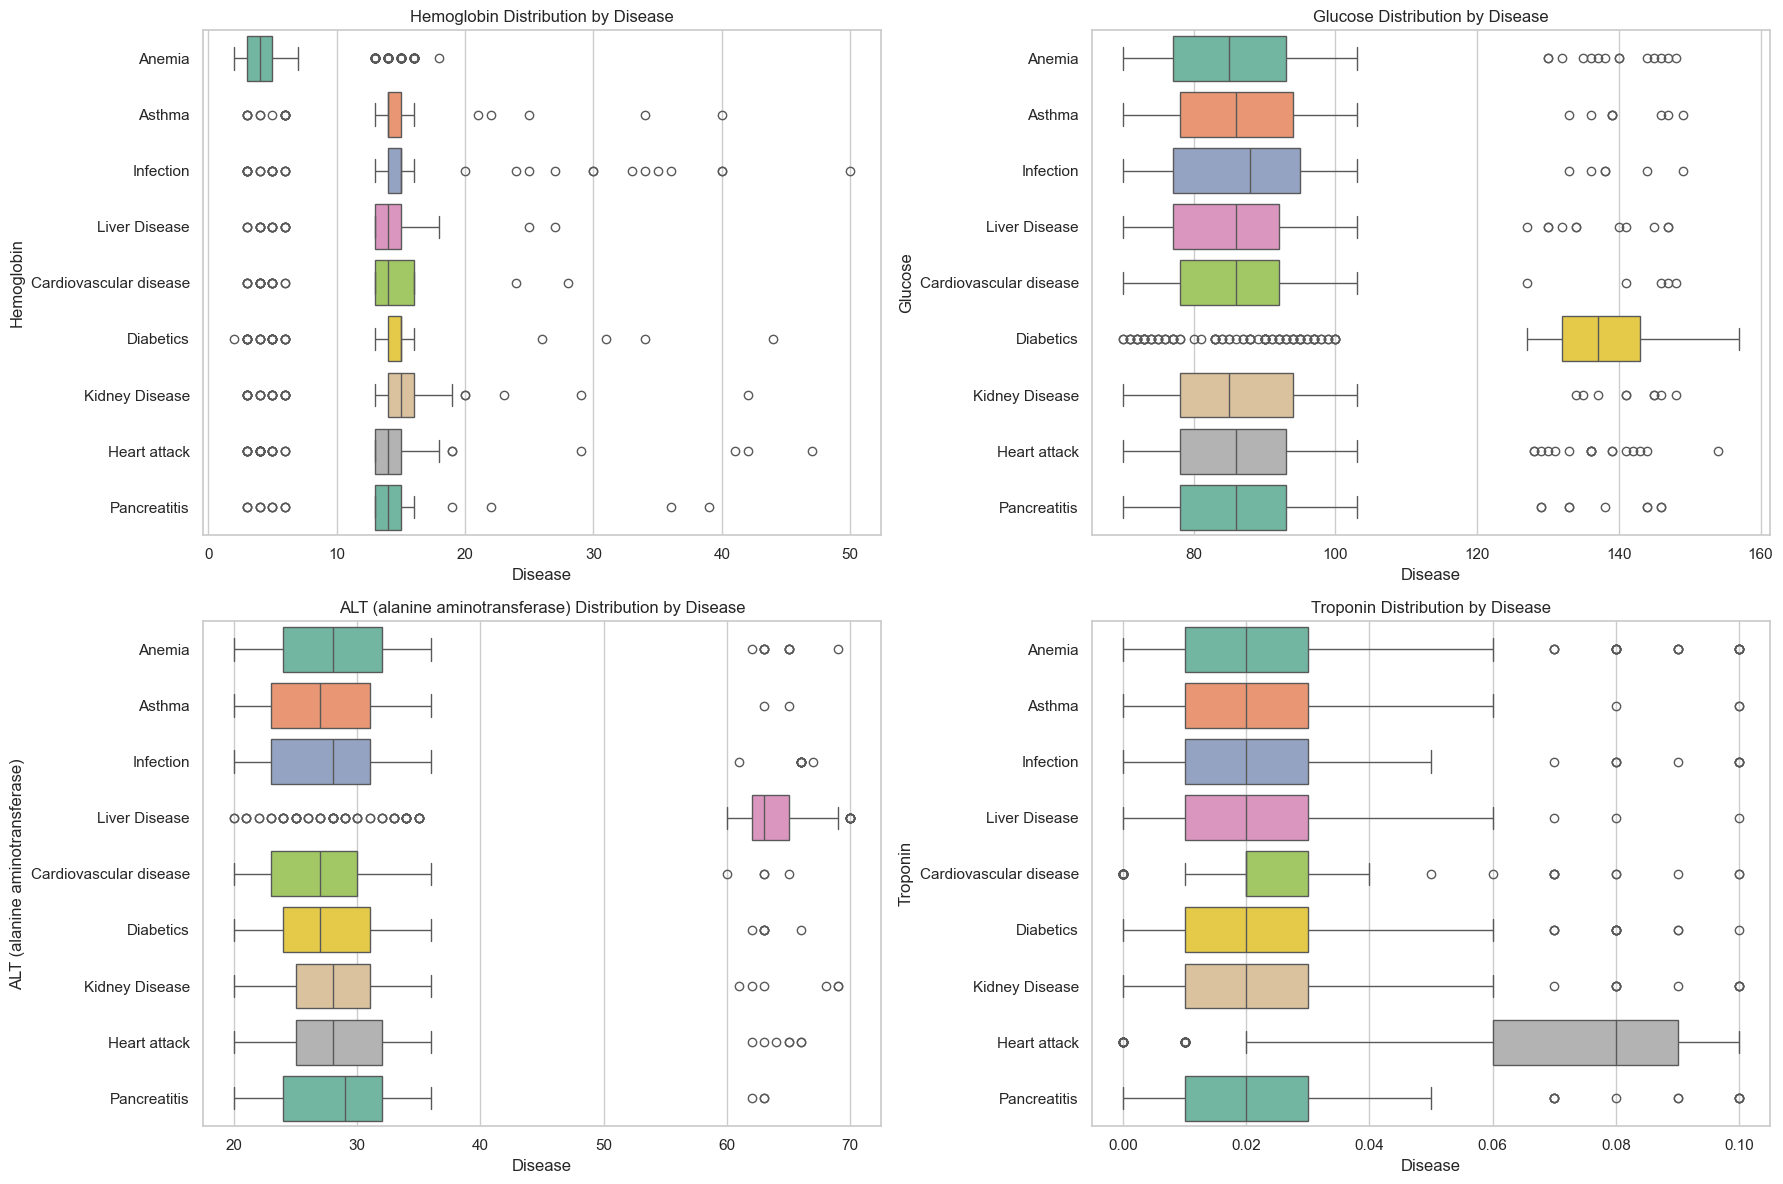

In [8]:
key_features = ['Hemoglobin', 'Glucose', 'ALT (alanine aminotransferase)', 'Troponin']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x=feature, y='Disease', data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{feature} Distribution by Disease')
    axes[i].set_xlabel('Disease')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Encoding and Splitting

##### We encode the categorical features and split the dataset into training and testing sets.

In [9]:
# Encoding categorical variables

# 1. Encode Gender variable
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# 2. Encode Disease variable
le = LabelEncoder()
df['Disease_encoded'] = le.fit_transform(df['Disease'])
target_name = le.classes_
print("Encoded Disease Classes:", target_name)

# 3. Seperate features and target
X = df.drop(columns=['Disease', 'Disease_encoded'], axis=1)
y = df['Disease_encoded']


# 4. Train-test split (70/30) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

print("Training set shape:", {X_train.shape[0]})
print("Test set shape:", {X_test.shape[0]})


Encoded Disease Classes: ['Anemia' 'Asthma' 'Cardiovascular disease' 'Diabetics' 'Heart attack'
 'Infection' 'Kidney Disease' 'Liver Disease' 'Pancreatitis']
Training set shape: {8406}
Test set shape: {3603}


In [10]:
df.head()

,Gender,Age,Hemoglobin,RBC,WBC,AST (aspartate aminotransferase),ALT (alanine aminotransferase),Cholestrol,Spirometry,Creatinine,Glucose,Lipase,Troponin,Disease,Disease_encoded
0,1,59,6,1.20,6220,26,22,227,4.75,0.90,96,97,0.02,Anemia,0
1,1,71,40,20.00,6636,18,27,220,3.93,1.03,94,82,0.04,Asthma,1
2,0,22,14,3.55,18314,21,30,224,3.93,1.17,70,101,0.00,Infection,5
3,1,53,16,4.95,9931,45,62,205,3.58,0.81,82,108,0.03,Liver Disease,7
4,1,77,16,3.96,7088,29,25,217,3.20,1.70,97,107,0.04,Liver Disease,7


#### Scaling and SMOTE
#####  Scaling ensures that all features contribute equally to model training, while SMOTE addresses any class imbalance observed in EDA.


In [11]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)
# Handling class imbalance with SMOTE
# SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class to balance the dataset.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"New training set size after SMOTE: {X_train_resampled.shape[0]}")
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())



[[-0.96768806 -0.57740044  0.63802135 ...  0.34459334 -0.67694487
   0.09457073]
 [-0.96768806 -0.90598261  0.21304453 ... -0.5335125   0.65603022
  -0.75976732]
 [-0.96768806 -0.81210199  0.85050976 ...  0.07018527  0.62000386
  -0.75976732]
 ...
 [-0.96768806 -1.70396789  0.21304453 ...  0.23483011 -0.38873404
   0.09457073]
 [-0.96768806  1.48797322  0.42553294 ... -0.03957796  0.36781939
  -0.75976732]
 [-0.96768806 -0.90598261  0.21304453 ... -0.5335125   0.65603022
  -0.75976732]]
New training set size after SMOTE: 18765
Class distribution after SMOTE:
Disease_encoded
5    2085
7    2085
6    2085
0    2085
1    2085
3    2085
4    2085
8    2085
2    2085
Name: count, dtype: int64


### 3. Model Building & Comparison
##### We evaluate four different architectures using 5-fold cross-validation on the balanced training data.

In [12]:
def evaluate_cv(model, name, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name} - Mean CV Accuracy: {scores.mean():.4f} ± {scores.std()* 2:.4f}")
    return scores.mean()

In [14]:
# 1. Building a Logistic Regression model
lr = LogisticRegression(random_state=42, max_iter=1000)
evaluate_cv(lr, "Logistic Regression", X_train_resampled, y_train_resampled)

# 2. Building a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_cv(rf, "Random Forest", X_train_resampled, y_train_resampled)

# 3. Building an XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
evaluate_cv(xgb, "XGBoost", X_train_resampled, y_train_resampled)

# 4. Building a simple Neural Network
def build_nn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dropout(0.2), 
        Dense(32, activation='relu'),
        Dense(len(target_name), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Logistic Regression - Mean CV Accuracy: 0.9325 ± 0.0025
Random Forest - Mean CV Accuracy: 0.9195 ± 0.0041
XGBoost - Mean CV Accuracy: 0.9462 ± 0.0025


In [16]:
# print ("Training Neural Network...") accuracy = []
nn = build_nn()
history = nn.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
nn_eval = nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network - Test Accuracy: {nn_eval[1]:.4f}")

Neural Network - Test Accuracy: 0.9367


## 4. Hyperparameter Tuning

#### XGBoost and Logistic Regression performed best, we perform a randomized search to optimize its parameters.

In [18]:
# Hyperparameter grid for XGBoost Classifier
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
param_distributions=xgb_param_grid,
 n_iter=20, cv=3, scoring='accuracy', 
 random_state=42, n_jobs=-1)

random_search.fit(X_train_resampled, y_train_resampled)

print("Best Hyperparameters for XGBoost:", random_search.best_params_)
best_xgb = random_search.best_estimator_


MemoryError: Unable to allocate 1.24 MiB for an array with shape (12510, 13) and data type float64

## 5. Model Evaluation
#### We evaluate the model on the test set 



In [ ]:
y_pred = best_xgb.predict(X_test_scaled)
y_proba = best_xgb.predict_proba(X_test_scaled)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_name))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_name, yticklabels=target_name)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

### ROC-AUC Curves

In [ ]:
# ROC Curve and AUC for each class
plt.figure(figsize=(12, 8))
for i in range(len(target_name)):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC Curve of {target_name[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

## 6. Feature Importance & Interpretation
#### Evaluating Global Importance

In [ ]:
importances = best_xgb.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### SHAP 
#### SHAP (SHapley Additive Explanations) provide a game theoretic approach to explain the output of machine learning models

In [ ]:
# Summary plot
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

plt.title('SHAP Summary Plot')
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, class_names=target_name)


# Force plot for a single prediction (e.g., the first test sample)
# For multi-class classification, we can visualize the SHAP values for a specific class (first class (index 0)).

patient_index = 0
class_index = 0  # Change this to visualize for a different class

print(f"SHAP values for patient index {patient_index} and class '{target_name[class_index]}':")
shap.initjs()
shap.force_plot(
    explainer.expected_value[class_index], shap_values[class_index][patient_index], X_test.iloc[patient_index], matplotlib=True)

## 7. Conclusion

""" Key Insights
   - Model Performance: The XGBoost model achieved high accuracy and F1-scores across most classes, proving its
     effectiveness in handling non-linear laboratory data.
   - Critical Features: Features like Hemoglobin, Glucose, and Troponin were identified as top predictors, aligning with
     clinical expectations (e.g., Glucose for Diabetes, Troponin for Heart Attack).
   - Data Quality: SMOTE was essential in balancing the dataset, which improved the recall for minority disease classes.


  Limitations & Future Work
   - Static Data: The current model uses a snapshot of lab values; incorporating longitudinal data could improve
     predictive power.
   - Deep Learning: While XGBoost performed well, more complex architectures like Transformer-based models for tabular
     data could be explored if the dataset size increases significantly."""